In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
# Google Drive Mount

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/Shareddrives/컨디션난조,분위기고조/실습과제/2주차/

/content/gdrive/Shareddrives/컨디션난조,분위기고조/실습과제/2주차


In [ ]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')

# 1. Data Explanation

Attribute Information

1) id: 환자 분별 id

2) gender: 성별, "Male", "Female", "Other"

3) age: 환자의 나이

4) hypertension: 환자에게 고혈압이 없는 경우 0, 있는 경우 1

5) heart_disease: 환자에게 심장병이 없는 경우 0, 있는 경우 1

6) ever_married: 결혼 여부, "No", "Yes"

7) work_type: 고용 상태, "children", "Govt_jov", "Never_worked", "Private", "Self-employed"

8) Residence_type: 거주 지역, "Rural", "Urban"

9) avg_glucose_level: 평균 혈중 글루코스(당) 수치

10) bmi: 체질량 지수

11) smoking_status: 흡연 상태, "formerly smoked", "never smoked", "smokes", "Unknown"*

12) stroke: 환자에게 뇌졸중이 있었을 경우 1, 아닌경우 0

*Note: smoking_status컬럼에서 환자의 상태를 알 수 없을 경우 "Unknown"으로 표기하였다.

In [ ]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [ ]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

전체 컬럼 중 age, avg_glucose_level, bmi를 categorical data, 나머지 컬럼들을 수치형 데이터로 보고 eda를 진행하였다. 또 레코드의 개별 id인 id컬럼은 유의미하지 않다고 판단하여 제거해주었다.



또, age 컬럼의 경우 1세 이하의 영유아에 대해서만 소수점을 가지고 나머지의 경우 int형식을 가지고있었기 때문에, 전반적으로 소수점을 버림하여 int로 통일하였다.

In [ ]:
df['age'] = df['age'].apply(lambda x: int(x))
df.drop('id', axis=1, inplace=True)
for i in ['gender','hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status', 'stroke']:
  df[i] = df[i].apply(lambda x: str(x))

In [ ]:
df.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.215264,106.147677,28.893237
std,22.633866,45.283560,7.854067
min,0.000000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 2. EDA

## 수치형 변수 EDA

avg_glucose_level의 히스토그램
: 정규분포 봉우리가 두개가 보이는 Gaussian Mixture Model로 보거나 왼쪽으로 치우친 분포라고 볼 수 있다. 특별히 이상치라고 볼만한 수치는 발견되지 않았다.

In [ ]:
fig = px.histogram(df, x="avg_glucose_level")
fig.show()

bmi의 히스토그램 : 정규분포와 매우 유사하다고 할 수 있다. 하지만 이상치로 보이는 레코드가 몇 건 있을 것으로 예상되어 box plot을 통한 확인을 거친 후 결과에 따라 이상치에 민감한 min-max scaling은 지양하는 것이 올바른 방향으로 보인다.

In [ ]:
fig = px.histogram(df, x="bmi")
fig.show()

age의 히스토그램 : 다른 수치형 변수에 비해 비교적 고른 분포를 보이는 것을 확인할 수 있었다. 특별한 이상치 또한 확인할 수 없었다.

In [ ]:
fig = px.histogram(df, x="age", nbins =82)
fig.show()

## 수치형 변수의 stroke과의 상관관계

아래는 예측해야할 label인 stroke를 기준으로 각 수치형 분포를 boxplot으로 시각화해보았다.


: stroke여부에 따른 avg_glucose_level의 분포를 보았을때 두 분포의 중앙값과 q3가 크게 다른 것을 확인할 수 있었다. 이에 avg_glucose_level은 stroke 예측/분류에 좋은 변수라고 판단할 수 있다.

In [ ]:
fig = px.box(df, x="stroke", y="avg_glucose_level")
fig.show()

stroke여부에 따른 bmi의 분포 보았을때 0의 경우 표본의 수가 많아 넓게 퍼져있는 반면 1의 경우 비교적 좁게 분포하였다. 중앙값 및 q1,q2,q3가 크게 다르지 않아 bmi의 stroke과의 상관관계를 추가로 확인해야할 필요가 있다.

In [ ]:
fig = px.box(df, x="stroke", y="bmi")
fig.show()

반면 나이의 경우 stroke와 큰 연관성이 있다고 볼 수 있었다. stroke 0에서는 나이가 전반적으로 고르게 분포하는 반면, 1에서는 0~30세 사이에 분포하는 건수는 2건에 불과했고 나머지는 모두 30대 이상의 나이를 가지는 것을 확인하였다.


In [ ]:
fig = px.box(df, x="stroke", y="age")
fig.show()

추가로 수치형 변수간 pearson상관계수도 확인해보았다. 절댓값 0.3~0.4이상을 상관관계가 크다고 이야기할 수 있는데, 눈에띄게 큰 상관관계를 가지는 수치형 변수는 확인하기 어려웠다.

In [ ]:
df.corr()

,age,avg_glucose_level,bmi
age,1.000000,0.238060,0.333738
avg_glucose_level,0.238060,1.000000,0.175502
bmi,0.333738,0.175502,1.000000


마지막으로 모든 수치형 변수의 각 분포와 변수간 산점도를 다음과 같이 한번에 확인할 수 있다.

앞서 시각화한 히스토그램, boxplot, 그리고 pearson 상관관계에서 확인할 수 있었던 결과와 크게 다르지 않은 모습이다.

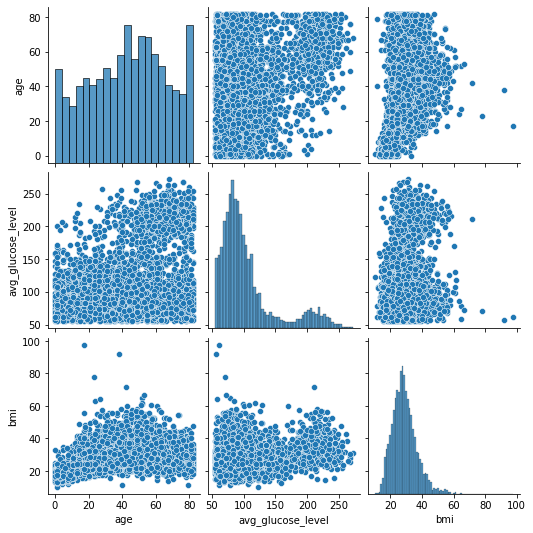

In [ ]:
sns.pairplot(df)
plt.show()

## 범주형 변수 EDA

Target인 stroke의 label 분포 : 0인 레코드 수는 4861, 1인 레코드 수는 249로 1인 레코드가 전체의 4.9%인 것을 확인할 수 있었다. 우리의 research question 중 stroke의 예측/분류 문제를 풀기 위해서는 이러한 imbalanced dataset을 그대로 활용할 경우 모델이 데이터를 제대로 학습하지 못하는 문제가 발생할 수 있다. 이러한 문제를 방지하기 위해 Random oversampling이나 범주형 데이터와 수치형데이터 모두에 적용 가능한 SMOTE-NC를 활용한 전처리가 필요할 것으로 보인다.

In [ ]:
temp = df.groupby('stroke').count()[['bmi']].reset_index()
temp.columns = ['stroke','count']
fig = px.bar(temp, x='stroke', y='count')
fig.show()

gender의 분포 : 전체 5110건 중 2994건이 여성, 2115건이 남성, 1건이 other인 것을 확인하였다. other의 경우 전체에서의 비율이 매우 적고 의미적으로 모호하므로 추후 해당 레코드를 제거할 필요가 있다.

In [ ]:
temp = df.groupby('gender').count()[['bmi']].reset_index()
temp.columns = ['gender','count']
fig = px.bar(temp, x='gender', y='count')
fig.show()

나머지 범주형 데이터에 대해서는 한번에 각 라벨의 수를 barplot으로 시각화해보았다.


: 고혈압 여부, 심장병 발생 여부에 대해서는 0,1의 비율이 크게 다른것을 확인할 수 있었다. 그 외의 경우 대부분의 라벨이 비교적 고르게 분포하였다. 각 범주형 데이터에 대해 라벨의 종류가 2가지인경우 0,1로 인코딩할 수 있다. 

그와 달리 smoking_status의 라벨은 never smoked, Unkown, formerly smoked, smokes로 총 4가지 이다. 나쁨, 중간, 좋음과 같은 단계적 범주형데이터의 경우 1,2,3과 같이 증가하는 숫자로 인코딩할 수 있겠지만, smoking status의 경우 Unkown이 포함되어 있어 위의 예시처럼 인코딩하기는 어렵다고 판단하여 one hot encoding을 진행하였다.

work type의 경우 라벨이 여러개인 점, 각 라벨간의 관계를 대,소 상,하관계로 보기 어려운 점을 고려하여 one-hot encoding을 진행하였다.

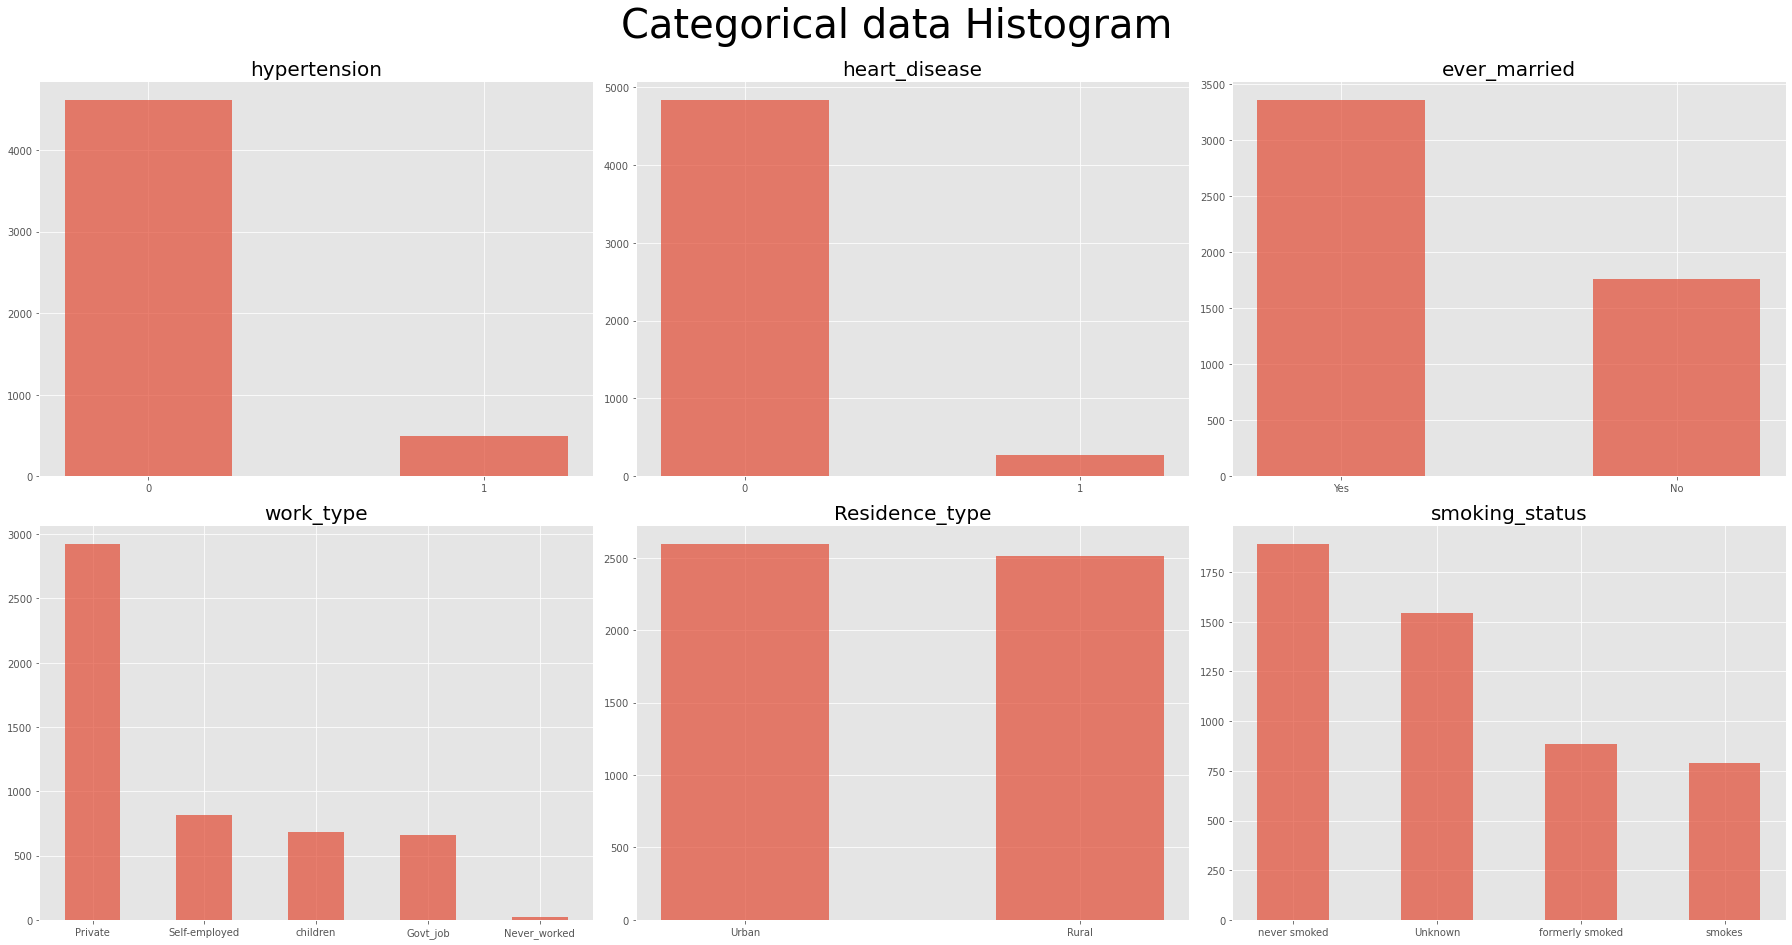

In [ ]:
plt.style.use("ggplot")

# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(25,20))
plt.suptitle("Categorical data Histogram", fontsize=40)

# id는 제외하고 시각화합니다.
cols = ['hypertension', 'heart_disease', 'ever_married', 'work_type',
        'Residence_type','smoking_status']
for i in range(0, len(cols)):
    plt.subplot(3,3,i+1)
    plt.title(cols[i], fontsize=20)
    temp = df[cols[i]].value_counts()
    plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
    plt.xticks(temp.keys())
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 범주형 데이터간의 상관관계 확인

참고 : https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix

범주형 데이터간의 상관관계는 Cramers'V 계수로 확인해볼 수 있다. 아래와 같이 계산할 수 있는 Cramers'V 계수는 두개의 범주형 변수가 얼마나 강력하게 연관되는지를 표현한다.이 값은 항상 0~1사이의 양수값을 가지는데, 1에 가까울수록 그 연관관계가 크다고 해석할 수 있다. 대체로 계수 ≤ 0.2일때는 약한 상관관계,0.2 < 계수 ≤ 0.6는 적당한 상관관계, 계수 > 0.6	의경우 강한 상관관계를 가진다고 해석한다.



 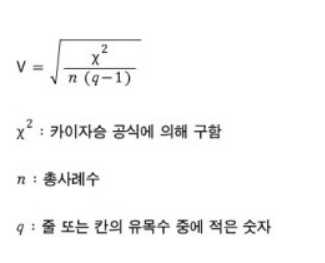



In [ ]:
data = df[['gender','hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status', 'stroke']]
label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in data.columns :
  data_encoded[i]=label.fit_transform(data[i])

In [ ]:
def cramers_V(var1,var2) :
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Crosstab building
  chi2 = chi2_contingency(crosstab)[0]
  n = np.sum(crosstab)
  phi2 = chi2 / n
  r, k = crosstab.shape
  phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
  rcorr = r - ((r-1)**2)/(n-1) 
  kcorr = k - ((k-1)**2)/(n-1)
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [ ]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2))
  rows.append(col)
  
cramers_results = np.array(rows)
crs = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)


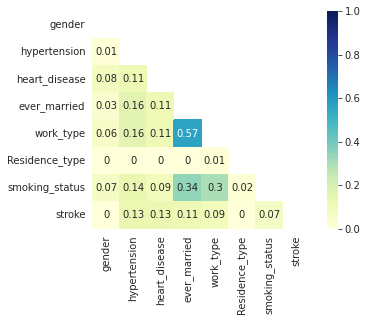

In [ ]:
mask = np.zeros_like(crs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


with sns.axes_style("white"):
  ax = sns.heatmap(crs, mask=mask,vmin=0., vmax=1, square=True, annot = True, cmap="YlGnBu")

plt.show()

결과는 위의 히트맵과 같이 나타난다. work_type과 ever_married 컬럼의 상관관계, smoking status와 ever_married, work_type 외에는 모두 두 범주형 변수간 약한 상관관계를 나타낸다. 하지만 그렇다고해서 해당 변수들을 현재 단계에서 모두 제거하기 보다는, 이후 전진선택법이나 후진 소거법과 같은 변수 선택 단계를 거쳐 변수를 제거하거나 삭제하도록 한다.

# 3. Data Imputation

결측치 확인
: bmi컬럼에서만 총 201건 결측치를 확인하였다.

In [ ]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

어떤 결측치 처리 방법을 사용할지 결정하기 위해 bmi열의 분포를 확인해보았다.

In [ ]:
fig = px.histogram(df, x="bmi")
fig.show()

대체로 정규분포를 따른다고 볼 수 있겠으나 70이상의 매우 큰 bmi의 레코드들을 몇 건 확인할 수 있었다. 이에 이상치에 덜 민감한 median으로 결측치를 채워주었다.

In [ ]:
med = np.median(np.array(df['bmi'].dropna()))
med

28.1

In [ ]:
df = df.fillna(med)

In [ ]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# 4. Data Sampling

undersampling 시 너무 많은 데이터를 제거하게 되어 정보 손실이 발생할 것을 우려하여 oversampling을 택하였다. 동일한 데이터를 단순히 증식시켜버리면 과적합이 발생하기 때문에, 개별 데이터들의 K 최근접 이웃을 찾아 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간만 차이가 나는 새로운 데이터를 생성하는 SMOTE 기법을 사용하고자 하였다. 우리 조가 가진 데이터의 경우에 범주형 변수를 포함하고 있었기 때문에 범주형 변수와 연속형 변수 모두에 적용할 수 있는 SMOTE-NC 기법을 사용하게 되었다.

In [ ]:
x = df.drop(columns = 'stroke')
y = df['stroke']

In [ ]:
cat_list = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
x.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

In [ ]:
# 범주형 변수를 갖는 컬럼의 인덱스를 배열로 받아 전달
oversample = SMOTENC([0, 4, 5, 6, 9], random_state = 2022)
x_over, y_over = oversample.fit_resample(x, y)
print(y_over.value_counts())

1    4861
0    4861
Name: stroke, dtype: int64


# 5. Data Partitioning

data sampling 이후, row 개수가 9722개로 유의미한 test set을 확보하기 위하여, train:test=7:3의 비율로 데이터를 나누었다. 타겟 변수인 'stroke'는 범주형 변수였기 때문에 stratified sampling을 사용하였다.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, train_size=0.7, test_size=0.3, stratify = y_over, random_state = 2022)

In [ ]:
print('train set: %d, test set: %d' %(len(y_train), len(y_test)))

train set: 6805, test set: 2917


In [ ]:
print('train set 1 비율: %f, 0 비율: %f' %(y_train.value_counts(1)[0], y_train.value_counts(1)[1]))
print('test set 1 비율: %f, 0 비율: %f' %(y_test.value_counts(1)[0], y_test.value_counts(1)[1]))

train set 1 비율: 0.500073, 0 비율: 0.499927
test set 1 비율: 0.500171, 0 비율: 0.499829


# 6. Outlier Detection

노이즈 제거 : EDA과정에서 'gender'라는 컬럼의 값은 전체 5110건 중 2994건이 여성, 2115건이 남성, 1건이 other인 것을 확인하였다.

여기서 other의 경우 1개로 전체에서의 비율이 매우 적고 그 의미를 분석하기에 모호하므로 노이즈로 판단하여 해당 row를 제거한다.

In [ ]:
index = x_train[x_train['gender']== 'Other'].index
x_train = x_train.drop(index)

In [ ]:
# other이 사라지고 gender의 값이 male, female의 2가지 종류만 남았는지 확인한다.
x_train['gender'].value_counts()

Female    3999
Male      2806
Name: gender, dtype: int64

In [ ]:
index = x_test[x_test['gender']== 'Other'].index
x_test = x_test.drop(index)

In [ ]:
# 이상치 탐지하는 함수

def detect_outlier_test(d_cp, column):
  fraud = d_cp[column]
  quan_25 = np.percentile(fraud.values, 25)
  quan_75 = np.percentile(fraud.values, 75)

  iqr = quan_75 - quan_25
  iqr = iqr * 1.5
  lowest = quan_25 - iqr
  highest = quan_75 + iqr
  outlier_index = fraud[(fraud < lowest) | (fraud > highest)].index
  return outlier_index

In [ ]:
# outlier의 index를 저장한 배열의 길이가 331개로, 쉽게 outlier를 제거할 수 없음을 알 수 있다.
# 따라서 outlier를 제거하는 코드는 작성만 하고 주석처리 하였다.

'''for i in list(numeric_feature):
  outlier_index = detect_outlier_test(x_train, i)

outlier_index'''

'for i in list(numeric_feature):\n  outlier_index = detect_outlier_test(x_train, i)\n\noutlier_index'

# 7. Scaling

In [ ]:
# 수치형 변수 'age', 'avg_glucose_level', 'bmi' 에 대해서 스케일링 해주기

numeric_feature = x_train.columns[(x_train.dtypes==int) | (x_train.dtypes== float)]
numeric_feature

Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')

## Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

x_train_std = standard_scaler.fit_transform(x_train[['age', 'avg_glucose_level', 'bmi']])
x_test_std = standard_scaler.transform(x_test[['age', 'avg_glucose_level', 'bmi']])

각 수치형 변수들의 스케일링 전후 변화<br>
- red = 스케일링 전<br>
- skyblue = 스케일링 후

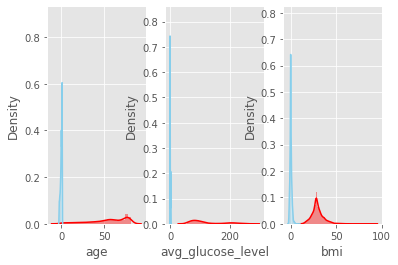

In [ ]:
fig, ax = plt.subplots(ncols=3)
sns.distplot(x_train['age'], color = "red", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train_std[:, 0], color = "skyblue", label = "Sepal Length", ax=ax[0])

sns.distplot(x_train['avg_glucose_level'], color = "red", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_std[:, 1], color = "skyblue", label = "Sepal Length", ax=ax[1])

sns.distplot(x_train['bmi'], color = "red", label = "Sepal Length", ax=ax[2])
sns.distplot(x_train_std[:, 2], color = "skyblue", label = "Sepal Length", ax=ax[2])

왼쪽 = 수치형 변수들의 스케일링 전

오른쪽 = 수치형 변수들의 스케일링 후

red = age, 
skyblue = avg_glucose_level, 
black = bmi

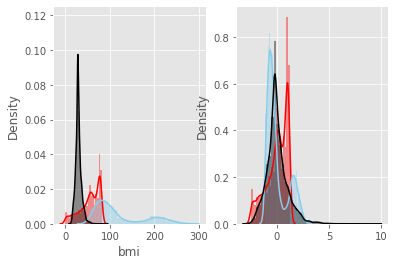

In [ ]:
fig, ax = plt.subplots(ncols=2)
sns.distplot(x_train['age'], color = "red", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train['avg_glucose_level'], color = "skyblue", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train['bmi'], color = "black", label = "Sepal Length", ax=ax[0])

sns.distplot(x_train_std[:, 0], color = "red", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_std[:, 1], color = "skyblue", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_std[:, 2], color = "black", label = "Sepal Length", ax=ax[1])

## MinMax Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()

x_train_mm = minmax_scaler.fit_transform(x_train[['age', 'avg_glucose_level', 'bmi']])
x_test_mm = minmax_scaler.transform(x_test[['age', 'avg_glucose_level', 'bmi']])

각 수치형 변수들의 스케일링 전후 변화<br>
- red = 스케일링 전<br>
- skyblue = 스케일링 후

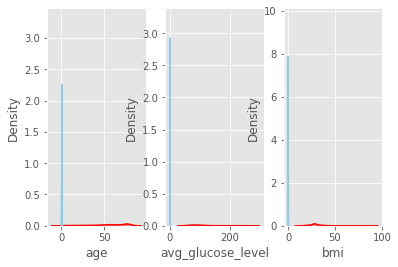

In [ ]:
fig, ax = plt.subplots(ncols=3)
sns.distplot(x_train['age'], color = "red", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train_mm[:, 0], color = "skyblue", label = "Sepal Length", ax=ax[0])

sns.distplot(x_train['avg_glucose_level'], color = "red", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_mm[:, 1], color = "skyblue", label = "Sepal Length", ax=ax[1])

sns.distplot(x_train['bmi'], color = "red", label = "Sepal Length", ax=ax[2])
sns.distplot(x_train_mm[:, 2], color = "skyblue", label = "Sepal Length", ax=ax[2])

왼쪽 = 수치형 변수들의 스케일링 전

오른쪽 = 수치형 변수들의 스케일링 후

red = age, 
skyblue = avg_glucose_level, 
black = bmi

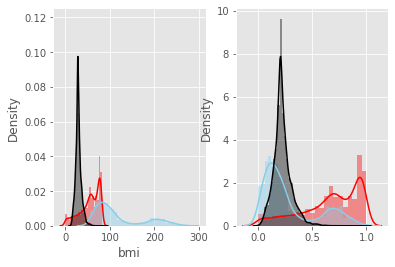

In [ ]:
fig, ax = plt.subplots(ncols=2)
sns.distplot(x_train['age'], color = "red", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train['avg_glucose_level'], color = "skyblue", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train['bmi'], color = "black", label = "Sepal Length", ax=ax[0])

sns.distplot(x_train_mm[:, 0], color = "red", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_mm[:, 1], color = "skyblue", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_mm[:, 2], color = "black", label = "Sepal Length", ax=ax[1])

## Robust Scaling

Robust Scaler는 중앙값과 사분위수를 사용하여 아웃라이어의 영향을 최소화하는 스케일링 방법이다.
이상치가 있는 경우에는 균형잡힌 척도를 보장할 수 없다. 현재 데이터 셋에서는 age, bmi등의 컬럼에서 이상치가 존재하는 알 수 있었다.
따라서 우리는 최종적으로 robust Scaler를 사용하여 중앙값이 0, 최대1, 최소 -1인 분포로 변환한다.

In [ ]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

x_train_rob = robust_scaler.fit_transform(x_train[['age', 'avg_glucose_level', 'bmi']])
x_test_rob = robust_scaler.transform(x_test[['age', 'avg_glucose_level', 'bmi']])

각 수치형 변수들의 스케일링 전후 변화<br>
- red = 스케일링 전<br>
- skublue = 스케일링 후

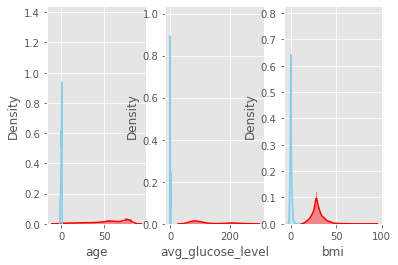

In [ ]:
fig, ax = plt.subplots(ncols=3)
sns.distplot(x_train['age'], color = "red", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train_rob[:, 0], color = "skyblue", label = "Sepal Length", ax=ax[0])

sns.distplot(x_train['avg_glucose_level'], color = "red", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_rob[:, 1], color = "skyblue", label = "Sepal Length", ax=ax[1])

sns.distplot(x_train['bmi'], color = "red", label = "Sepal Length", ax=ax[2])
sns.distplot(x_train_rob[:, 2], color = "skyblue", label = "Sepal Length", ax=ax[2])

왼쪽 = 수치형 변수들의 스케일링 전

오른쪽 = 수치형 변수들의 스케일링 후

red = age, 
skyblue = avg_glucose_level, 
black = bmi

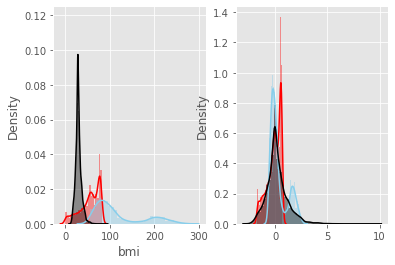

In [ ]:
fig, ax = plt.subplots(ncols=2)
sns.distplot(x_train['age'], color = "red", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train['avg_glucose_level'], color = "skyblue", label = "Sepal Length", ax=ax[0])
sns.distplot(x_train['bmi'], color = "black", label = "Sepal Length", ax=ax[0])

sns.distplot(x_train_rob[:, 0], color = "red", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_rob[:, 1], color = "skyblue", label = "Sepal Length", ax=ax[1])
sns.distplot(x_train_rob[:, 2], color = "black", label = "Sepal Length", ax=ax[1])

In [ ]:
#scaling한 값 x_train에 저장
x_train['age'] = x_train_rob[:, 0]
x_train['avg_glucose_level'] = x_train_rob[:, 1]
x_train['bmi'] = x_train_rob[:, 2]

x_train.describe()

,age,avg_glucose_level,bmi
count,6805.000000,6805.000000,6805.000000
mean,-0.122190,0.329668,0.159006
std,0.647112,0.831601,0.998698
min,-1.735294,-0.620977,-2.587163
25%,-0.529412,-0.275006,-0.386896
50%,0.000000,0.000000,0.000000
75%,0.470588,0.724994,0.613104
max,0.676471,2.653922,9.658461


In [ ]:
#scaling한 값 x_test에 저장
x_test['age'] = x_test_rob[:, 0]
x_test['avg_glucose_level'] = x_test_rob[:, 1]
x_test['bmi'] = x_test_rob[:, 2]

# 8. Transformation

왜도와 첨도를 조정하는 공식적인 기준은 정해진 바가 없으나, 주로 왜도가 -2에서 2, 첨도가 -7에서 7의 범위 내에 있을 때 조정이 필요 없다고 봄.<br> (출처:  https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/Simon)

In [ ]:
x_train = pd.DataFrame(x_train, columns = x_train.columns, index = x_train.index)
x_train.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
age,-0.780358,-0.349065
hypertension,1.657070,1.052174
heart_disease,2.361673,4.107998
avg_glucose_level,1.038877,-0.277211
bmi,1.023743,3.582449


수치형 변수인 'age', 'avg_glucose_level', 'bmi' 모두 왜도의 절댓값이 2 이하이고 첨도의 절댓값이 7 이하이기 때문에 조정이 필요없다고 판단하여 Transformation을 거치지 않았다.

# 9. Categorical Encoding

gender, ever_married, Residence_type

In [ ]:
x_train[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]

,gender,ever_married,work_type,Residence_type,smoking_status
2609,Male,Yes,Govt_job,Rural,never smoked
1313,Male,Yes,Private,Rural,smokes
1042,Female,No,Self-employed,Urban,never smoked
7953,Male,Yes,Private,Urban,Unknown
3892,Male,Yes,Govt_job,Urban,Unknown
...,...,...,...,...,...
4199,Female,Yes,Private,Rural,formerly smoked
7433,Male,Yes,Private,Rural,never smoked
1867,Female,Yes,Private,Rural,Unknown
9073,Male,Yes,Private,Urban,smokes


In [ ]:
label_encoder = LabelEncoder()

x_train['gender'] = label_encoder.fit_transform(x_train['gender'])
x_test['gender'] = label_encoder.transform(x_test['gender'])
x_train['ever_married'] = label_encoder.fit_transform(x_train['ever_married'])
x_test['ever_married'] = label_encoder.transform(x_test['ever_married'])
x_train['Residence_type'] = label_encoder.fit_transform(x_train['Residence_type'])
x_test['Residence_type'] = label_encoder.transform(x_test['Residence_type'])

In [ ]:
x_train[['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']]

,gender,ever_married,work_type,Residence_type,smoking_status
2609,1,1,Govt_job,0,never smoked
1313,1,1,Private,0,smokes
1042,0,0,Self-employed,1,never smoked
7953,1,1,Private,1,Unknown
3892,1,1,Govt_job,1,Unknown
...,...,...,...,...,...
4199,0,1,Private,0,formerly smoked
7433,1,1,Private,0,never smoked
1867,0,1,Private,0,Unknown
9073,1,1,Private,1,smokes


- gender

Female: 0, Male: 1

- ever_married

No: 0, Yes: 1

- Residence_type

Rural: 0, Urban: 0






## One-hot encoding
work_type, smoking_status

In [ ]:
dummies = pd.get_dummies(x_train[['work_type', 'smoking_status']]) # 모든 범주형 변수를 한 번에 더미변수로 처리해줌
x_train = x_train.join(dummies)

In [ ]:
dummies = pd.get_dummies(x_test[['work_type', 'smoking_status']]) # 모든 범주형 변수를 한 번에 더미변수로 처리해줌
x_test = x_test.join(dummies)

In [ ]:
x_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2609,1,0.000000,0.0,0.0,1,Govt_job,0,2.052370,0.735999,never smoked,1,0,0,0,0,0,0,1,0
1313,1,-0.264706,0.0,0.0,1,Private,0,-0.047696,2.056159,smokes,0,0,1,0,0,0,0,0,1
1042,0,0.676471,0.0,0.0,0,Self-employed,1,-0.211425,-0.356548,never smoked,0,0,0,1,0,0,0,1,0
7953,1,0.000000,0.0,0.490752,1,Private,1,1.733191,-0.037888,Unknown,0,0,1,0,0,1,0,0,0
3892,1,-0.647059,0.0,0.0,1,Govt_job,1,1.175818,-0.311025,Unknown,1,0,0,0,0,1,0,0,0


In [ ]:
print(x_train.shape)
print(x_test.shape)

(6805, 19)
(2916, 19)
